Este programa utiliza comandos SQL para obtener datos de exoplanets.eu, luego hace una comparación entre algunas técnicas

$PARTE 1$

Un analisis previo consistió en traer todas las columnas y buscar las que necesitaba. Para eso limité el período a que sea menor a 3 dias (arbitrario). Ese análisis no lo dejo explícito, sólo esta línea comentándolo.
El query era: query = "SELECT * FROM exoplanet.epn_core WHERE period<3"

Luego hice un query ya trayendo las columnas que necesito y también limitando un poco los datos (periodos no negativos, masas menores a ~15 Mjup, etc

(falta completar)

-------------



In [1]:
%matplotlib inline 
import numpy as np 
import matplotlib.pyplot as plt
import pyvo
# Estilo de gráficos
plt.style.use('dark_background')
# Servicio pyvo
service = pyvo.dal.TAPService("http://voparis-tap-planeto.obspm.fr/tap")

Consideraré planetas y no enanas marrones => mass < ~15Mjup y filtraré los periodos para que no sean negativos

In [2]:
query = """SELECT period, mass, star_spec_type, detection_type
FROM exoplanet.epn_core
WHERE mass<15 AND period>0 AND star_distance>0"""

In [3]:
res = service.search(query);

In [4]:
# Veo el primer planeta de los resultados
res.table[:2]

period,mass,star_spec_type,detection_type
d,'jupiterMass',,
float64,float64,object,object
10260.0,2.6,F0IV,Imaging
4.2308,0.47,G2 IV,Radial Velocity


In [5]:
# Obtengo los valores de las columnas en listas con un loop
size = np.shape(res) # size[0] es la cantidad de exoplanetas que tengo
P = [] # Períodos
Mass = [] # Masas
Spec = [] # Tipo espectral
Tec = [] # Técnica de detección

ij = 0
while ij < size[0]:
    P.append( res.getvalue(name='period', index=ij) )
    Mass.append( res.getvalue(name='mass', index=ij) )
    Spec.append( res.getvalue(name='star_spec_type', index=ij) )
    Tec.append( res.getvalue(name='detection_type', index=ij) )
    ij = ij + 1

Para simplicidad sólo consideraré algunas técnicas y no todas, armo listas con las posiciones de los planetas en función de la técnica y luego uso la función Clasif() para clasificarlos:

In [6]:
VR = []
Tran = []
TTV = []
Pulsar = []
ij = 0
while ij<size[0]:
    if Tec[ij] == b'Radial Velocity':
        VR.append(ij)
    if Tec[ij] == b'Primary Transit':
        Tran.append(ij)
    if Tec[ij] == b'TTV':
        TTV.append(ij)
    if Tec[ij] == b'Pulsar':
        Pulsar.append(ij)
    ij = ij + 1

In [7]:
def Clasif(X):
    """ Devuelve el periodo y masa para los planetas en función de su técnica de detección
    
    Parameters
    ----------
    X : list
        Lista con valores enteros que localizan a la técnica asociada al arreglo X. 
        Por ej: X:VR tendrá los valores para las posiciones de todos los planetas que fueron
        detectados por esa técnica. Si tengo 3 planetas y los dos últimos fueron detectados
        por VR => X = [1,2] ( NO es X=[0,1,2] )
        
    Returns
    -------
    Per, Masa : list, list
        Listas con los parámetros asociados a la técnica requerida
        
    """
    Per = []
    Masa = []
    for ij in X:
        Per.append(P[ij])
        Masa.append(Mass[ij])
    return (Per, Masa)

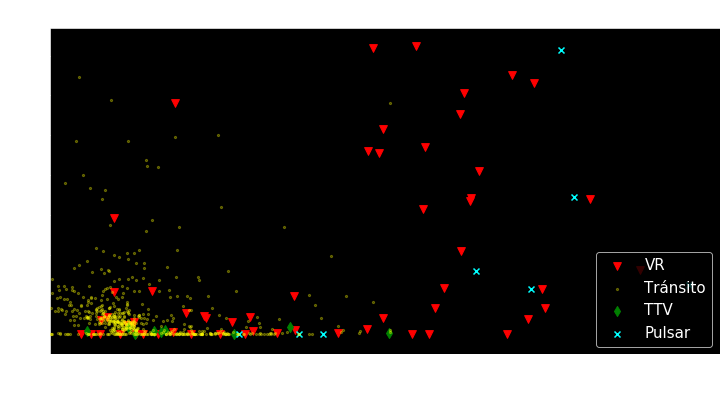

In [8]:
fig, ax = plt.subplots(1, 1, figsize = (12,6))

ax.scatter(Clasif(VR)[0], Clasif(VR)[1], color='red', zorder=0, marker='v', s=60,
          label='VR')
ax.scatter(Clasif(Tran)[0], Clasif(Tran)[1], color='yellow', zorder=10, alpha=0.3, s=5,
          label='Tránsito')
ax.scatter(Clasif(TTV)[0], Clasif(TTV)[1], color='green', marker='d', s=50,
          label='TTV')
ax.scatter(Clasif(Pulsar)[0], Clasif(Pulsar)[1], color='cyan', marker='x',
          label='Pulsar')

ax.set_xscale('log')
ax.set_title('Masa vs periodo', fontsize=20)
ax.set_ylabel('Masa [MJup]', fontsize=20)
ax.set_xlabel('Periodo [d]', fontsize=20);
ax.legend(fontsize=15, loc=4);

Comparación de técnicas: